# Install Libraries if Needed (Only Run Once)

In [65]:
!pip install -U deepxde
!pip install matplotlib
!pip install numpy
!pip install scipy
# !pip install -U tensorflow
# !pip install -U "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
# !pip install ipympl


# Import Libraries

In [2]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1

2021-11-17 10:19:51.286443: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term



# Burgers Equation

$$
u_t + u u_x = \frac{0.01}{\pi} u_{xx}, \quad x \in (-1, 1), t \in (0, 0.99],\\
u(x,0) = -\sin(\pi x), \\
u(-1,t) = u(1,t) = 0
$$

# Define Generate Test Data Function

In [3]:
def gen_testdata():
    data = np.load("dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    Nx = len(x)
    Nt = len(t)
    return X, y, Nx, Nt

# Define PDE

In [4]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define Geometry

In [5]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define ICs/BCs

In [6]:
bc = dde.DirichletBC(geomtime, # geometry
                     lambda x: 0, # value of specified boundary
                     lambda _, on_boundary: on_boundary # check if point is on specified boundary (function of coordinates and boolean on_boundary returns boolean)
                    )
ic = dde.IC(geomtime, # geometry
            lambda x: -np.sin(np.pi * x[:, 0:1]), # value of initial condition
            lambda _, on_initial: on_initial # check if point is an initial condition (function of coordinates and boolean on_initial returns boolean)
           )

# Construct Data (geometry + PDE + ICs/BCs)

In [7]:
data = dde.data.TimePDE(geomtime, # geometry
                        pde, # pde
                        [bc, ic], # ICs/BCs
                        num_domain=2540, # number of points in domain
                        num_boundary=80, # number of points on boundary
                        num_initial=160 # number of points on initial 
                       )

/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr2/.local/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [8]:
net = dde.maps.FNN([2] + [20] * 3 + [1], # layers
                   "tanh", # activation function
                   "Glorot normal" # initializer
                  )

# Define Model (data + net)

In [9]:
model = dde.Model(data, net)

# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [10]:
model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.081447 s



/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/miniconda3/envs/opence-v1.3.1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-11-17 10:20:30.075032: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-17 10:20:30.249171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1731] Found device 0 with properties: 
pciBusID: 0004:04:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.00GiB deviceMemory

'compile' took 1.405647 s

Initializing variables...
Training model...



2021-11-17 10:20:31.457928: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3783000000 Hz
2021-11-17 10:20:31.603632: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


Step      Train loss                        Test loss                         Test metric
0         [1.46e-02, 1.21e-02, 5.67e-01]    [1.46e-02, 1.21e-02, 5.67e-01]    []  


2021-11-17 10:20:32.341320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1000      [4.11e-02, 6.97e-04, 5.38e-02]    [4.11e-02, 6.97e-04, 5.38e-02]    []  
2000      [2.95e-02, 5.71e-05, 3.80e-02]    [2.95e-02, 5.71e-05, 3.80e-02]    []  
3000      [1.38e-02, 5.26e-05, 1.60e-02]    [1.38e-02, 5.26e-05, 1.60e-02]    []  
4000      [1.09e-02, 4.16e-05, 1.03e-02]    [1.09e-02, 4.16e-05, 1.03e-02]    []  
5000      [7.94e-03, 2.66e-05, 5.35e-03]    [7.94e-03, 2.66e-05, 5.35e-03]    []  
6000      [3.43e-03, 7.38e-06, 3.07e-03]    [3.43e-03, 7.38e-06, 3.07e-03]    []  
7000      [2.37e-03, 6.29e-06, 2.80e-03]    [2.37e-03, 6.29e-06, 2.80e-03]    []  
8000      [2.09e-03, 1.07e-05, 2.45e-03]    [2.09e-03, 1.07e-05, 2.45e-03]    []  
9000      [1.44e-03, 6.19e-06, 2.16e-03]    [1.44e-03, 6.19e-06, 2.16e-03]    []  
10000     [1.17e-03, 5.17e-06, 1.70e-03]    [1.17e-03, 5.17e-06, 1.70e-03]    []  
11000     [9.02e-04, 5.61e-06, 1.44e-03]    [9.02e-04, 5.61e-06, 1.44e-03]    []  
12000     [8.11e-04, 4.28e-06, 1.25e-03]    [8.11e-04, 4.28e-06, 1.25e-03]    []  
1300

Saving loss history to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/loss_Burgers.dat ...
Saving training data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/train_Burgers.dat ...
Saving test data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/test_Burgers.dat ...


<IPython.core.display.Javascript object>


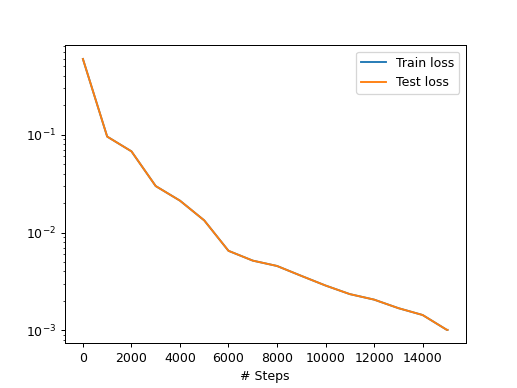

<IPython.core.display.Javascript object>


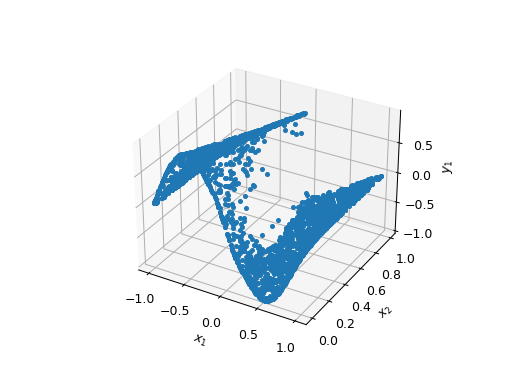

In [11]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers.dat', train_fname='train_Burgers.dat',test_fname='test_Burgers.dat')


# Load the Test Data

In [12]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.15770854892508437


In [13]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

<IPython.core.display.Javascript object>


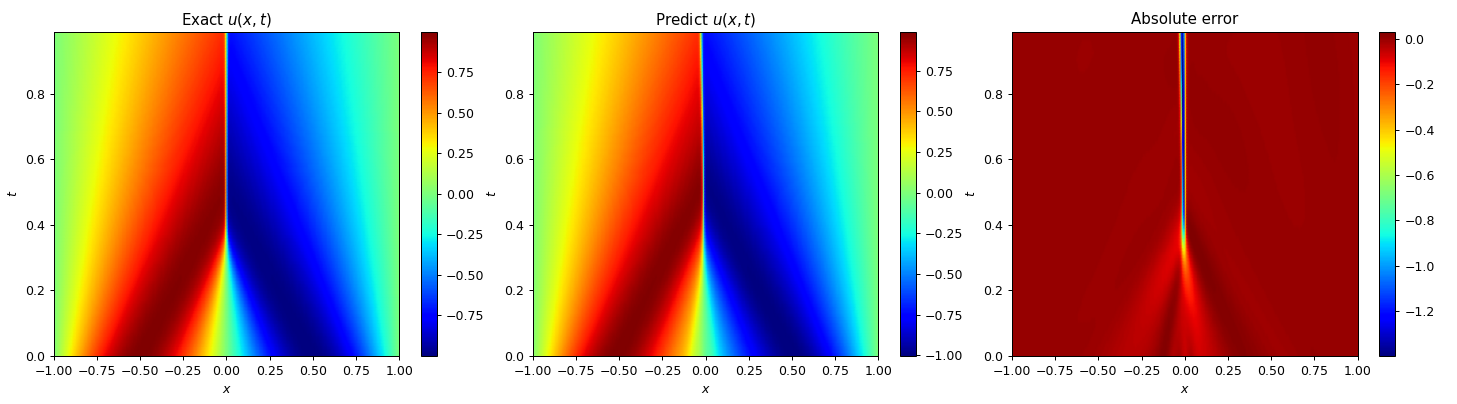

In [14]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


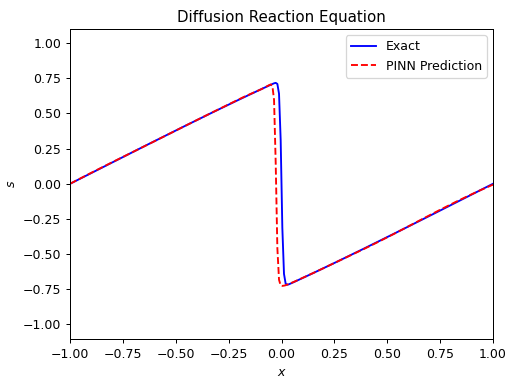

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()

# Optionally Refine by Adding Additional Points Near Potential Shock (True Shock Occurs at Low to Zero Viscosity)

In [18]:
X_reample = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X_reample, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X_reample[x_id], "\n")
    data.add_anchors(X_reample[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(
        epochs=10000, disregard_previous_best=True, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()

Mean residual: 2.421e-02
Adding new point: [-0.01740694  0.7807352 ] 

Compiling model...
'compile' took 0.276641 s

Training model...

Step      Train loss                        Test loss                         Test metric
15027     [1.14e-02, 3.19e-06, 5.06e-04]    [5.04e-04, 3.19e-06, 5.06e-04]    []  
16000     [6.14e-04, 2.95e-06, 5.67e-04]    [6.12e-04, 2.95e-06, 5.67e-04]    []  
17000     [5.29e-04, 2.19e-06, 4.89e-04]    [5.21e-04, 2.19e-06, 4.89e-04]    []  
18000     [4.74e-04, 1.83e-06, 4.32e-04]    [4.69e-04, 1.83e-06, 4.32e-04]    []  
19000     [4.21e-04, 2.05e-06, 3.87e-04]    [4.21e-04, 2.05e-06, 3.87e-04]    []  
20000     [3.99e-04, 1.47e-06, 3.45e-04]    [3.98e-04, 1.47e-06, 3.45e-04]    []  
21000     [3.80e-04, 1.69e-06, 3.15e-04]    [3.79e-04, 1.69e-06, 3.15e-04]    []  
22000     [3.64e-04, 1.47e-06, 2.87e-04]    [3.64e-04, 1.47e-06, 2.87e-04]    []  
Epoch 22000: early stopping

Best model at step 22000:
  train loss: 6.52e-04
  test loss: 6.52e-04
  test met

51029     [2.69e-05, 3.76e-08, 1.17e-05]    [2.64e-05, 3.76e-08, 1.17e-05]    []  

Best model at step 51029:
  train loss: 3.86e-05
  test loss: 3.81e-05
  test metric: []

'train' took 1.005008 s

Mean residual: 8.636e-03
Adding new point: [0.00164056 0.49605426] 

Compiling model...
'compile' took 0.327632 s

Training model...

Step      Train loss                        Test loss                         Test metric
51029     [2.49e-03, 3.76e-08, 1.17e-05]    [2.64e-05, 3.76e-08, 1.17e-05]    []  
52000     [3.66e-05, 1.02e-07, 4.83e-06]    [3.56e-05, 1.02e-07, 4.83e-06]    []  
53000     [2.26e-05, 7.13e-08, 4.52e-06]    [2.24e-05, 7.13e-08, 4.52e-06]    []  
54000     [2.44e-05, 9.27e-08, 4.02e-06]    [2.36e-05, 9.27e-08, 4.02e-06]    []  
Epoch 54000: early stopping

Best model at step 53000:
  train loss: 2.72e-05
  test loss: 2.69e-05
  test metric: []

'train' took 9.439313 s

Compiling model...
'compile' took 0.241298 s

Training model...

Step      Train loss                

Saving loss history to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/loss_Burgers_RAR.dat ...
Saving training data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/train_Burgers_RAR.dat ...
Saving test data to /home/shawngr2/HAL-Physics-Informed-AI-Tutorial/test_Burgers_RAR.dat ...


<IPython.core.display.Javascript object>


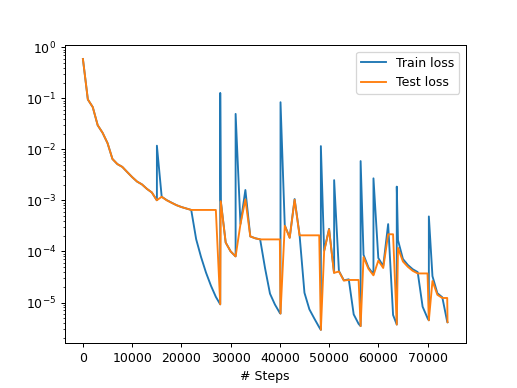

<IPython.core.display.Javascript object>


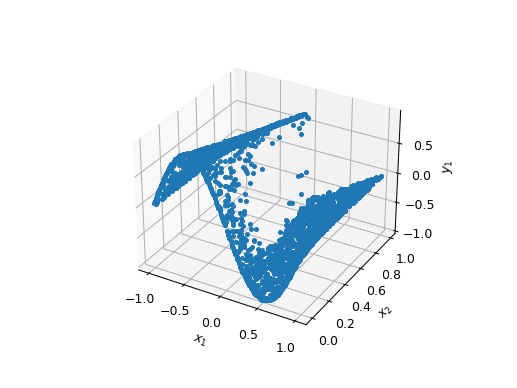

In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname='loss_Burgers_RAR.dat', train_fname='train_Burgers_RAR.dat',test_fname='test_Burgers_RAR.dat')


# Load the Test Data

In [20]:
x_test, y_true, Nx, Nt = gen_testdata()
y_pred = model.predict(x_test)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test_burgers.dat", np.hstack((x_test, y_true, y_pred)))

L2 relative error: 0.006802511238589478


In [21]:
X_test, T_test = x_test[:,0], x_test[:,1]
X = X_test.reshape((Nt, Nx))
T = T_test.reshape((Nt, Nx))
Y_pred = y_pred.reshape((Nt, Nx))
Y_test = y_true.reshape((Nt, Nx))

<IPython.core.display.Javascript object>


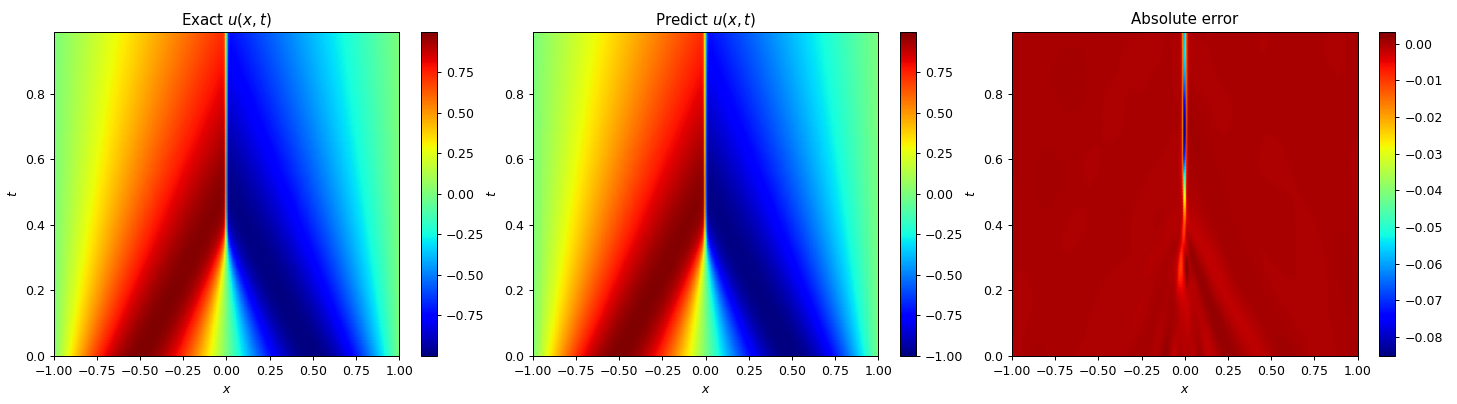

In [22]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $u(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, Y_pred - Y_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


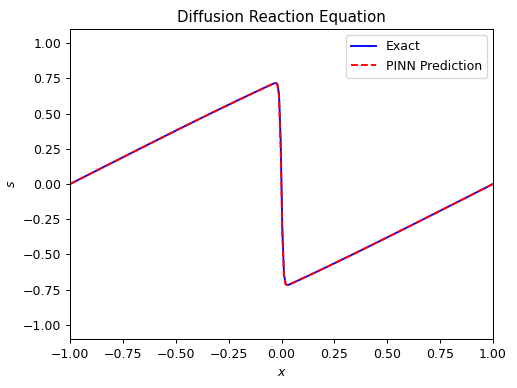

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, Y_test[0], 'b-', label='Exact')
ax.plot(x, Y_pred[0], 'r--', label='PINN Prediction')
ylim = plt.ylim()
xlim = [-1, 1]
plt.tight_layout()


for i in range(Nt):
    ax.clear()
    ax.plot(x, Y_test[i], 'b-', label='Exact')
    ax.plot(x, Y_pred[i], 'r--', label='PINN Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()